In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import numpy as np
import datetime
import gc

In [4]:
# sns.set(style="white")
plt.style.use("dark_background")

In [5]:
from utils import sql_table_to_pandas, str2iter_match_ratio
from plotting import plot_normalised_barplot, plot_countplot, plot_distplot

In [6]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 100,
    'display.float_format', '{:4,.2f}'.format
)


## Dataset description

- *status*: investigation status
- *time*: the time of accident
- *day*: the day of accident
- *month*: the monthe of accident
- *year*: the year of accdient
- *first_flight*: the year of aircraft first flight
- *total_airframe_hrs*: the hours that aircraft flied
- *aircraft_type*: the model of aircraft
- *operator*: the company, organisation or individual operating the aircraft at the time of the accident
- *country*: the country of accident
- *location*: more detailed location of accident
- *phase*: the phase of flight
- *nature*: the nature of the flight
- *engines*: number and type (model and mark) of engines
- *narrative*: the description of the occurrence
- *probable_cause*: the probable cause of the accident as established by the accident investigators
- *aircraft_damage*: describes the amount of damage to the airplane as a result of the occurrence
- *departure_airport*: the last airport of departure before the accident
- *destination_airport*: the scheduled destination airport
- *crew_occupants*: the exact number of flight- and cabincrew members aboard the aircraft at the time of departure
- *crew_fatalities*: the number of crew members who fatally injured as a direct result of the accident
- *passengers_occupants*: the number of passengers aboard the aircraft at the time of departure
- *passengers_fatalities*: the number of passengers who fatally injured as a direct result of the accident
- *total_occupants*: crew_occupants + passengers_occupants
- *total_fatalities*: crew_fatalities + passengers_fatalities

## Dataset cleaning

In [7]:
df = sql_table_to_pandas('../db_config.JSON', 'accidents')

In [8]:
# df_aircraft = sql_table_to_pandas('../db_config.JSON', 'aircraft')
# df_aircraft.columns = [c if 'aircraft' in c else f'aircraft_{c}' for c in df_aircraft.columns]
# df = pd.merge(df_accidents, df_aircraft, how='left', on='aircraft_type')

In [9]:
df = df.replace({None: np.nan, 'None': np.nan})

In [10]:
df.shape

(22767, 27)

###### time

In [11]:
def correct_time(x) -> datetime.time or np.nan:
    """Removes times which are not in local time of accident."""
    if pd.isnull(x):
        return np.nan
    
    # ca or c. means circa which translated from latin means approximate
    x = x.replace('ca', '').replace('c.', '').replace(' ', '')
    

    if re.match(r'^(2[0-3]|[01]?[0-9]):([0-5]?[0-9])$', x):
        return datetime.datetime.strptime(x, '%H:%M').time()
    elif re.match(r'^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$', x):
        return datetime.datetime.strptime(x, '%H:%M:%S').time()
    else:
        return np.nan


def get_time_range(x) -> str or np.nan:
    if pd.isnull(x):
        return np.nan

    if x < datetime.time(4, 0):
        return '00:00 - 03:59'
    elif x < datetime.time(8, 0):
        return '04:00 - 07:59'
    elif x < datetime.time(12, 0):
        return '08:00 - 11:59'
    elif x < datetime.time(16, 0):
        return '12:00 - 15:59'
    elif x < datetime.time(20, 0):
        return '16:00 - 19:59'
    else:
        return '20:00 - 23:59'

In [12]:
df['time_range'] = df['time'].apply(correct_time).apply(get_time_range)
df.drop(columns=['time'], inplace=True)

In [13]:
df['time_range'].value_counts()

12:00 - 15:59    1926
08:00 - 11:59    1892
16:00 - 19:59    1749
20:00 - 23:59    1118
04:00 - 07:59     888
00:00 - 03:59     571
Name: time_range, dtype: int64

###### weekday

No correction

In [14]:
df['weekday'].value_counts()

Friday       3513
Thursday     3359
Wednesday    3300
Tuesday      3298
Monday       3151
Saturday     3030
Sunday       2606
Name: weekday, dtype: int64

###### day

No correction

In [15]:
df['day'].value_counts()

10.00    890
24.00    791
15.00    778
27.00    769
19.00    763
23.00    753
6.00     750
13.00    745
18.00    742
17.00    742
11.00    739
12.00    738
22.00    736
9.00     736
4.00     735
28.00    732
14.00    728
7.00     722
26.00    719
21.00    708
25.00    707
16.00    706
2.00     705
8.00     698
5.00     683
3.00     679
30.00    676
20.00    671
1.00     662
29.00    654
31.00    400
Name: day, dtype: int64

###### month

No correction

In [16]:
df['month'].value_counts()

12.00    2013
1.00     2011
3.00     2001
9.00     1988
5.00     1956
7.00     1884
8.00     1835
6.00     1833
11.00    1828
4.00     1789
10.00    1746
2.00     1639
Name: month, dtype: int64

###### year

In [17]:
df['year'].iloc[:10]

0    1969
1    2020
2    2020
3    1971
4    1961
5    1961
6    1961
7    1961
8    1961
9    1961
Name: year, dtype: int64

In [18]:
df['decade'] = (df['year'] // 10 * 10).apply(lambda x: f'{x}s')

In [19]:
df['decade'].value_counts()

1940s    5694
1970s    2793
1960s    2546
1990s    2518
1950s    2330
1980s    2280
2000s    2170
2010s    1979
1930s     376
1920s      73
2020s       6
1910s       2
Name: decade, dtype: int64

###### first_flight

In [20]:
def get_age_range(age) -> str or np.nan:
    if pd.isnull(age):
        return np.nan
    
    if age < 1:
        return '0 - 1'
    elif age < 3:
        return '1 - 3'
    elif age < 5:
        return '3 - 5'
    elif age < 10:
        return '5 - 10'
    elif age < 20:
        return '10 - 20'
    elif age < 30:
        return '20 - 30'
    elif age < 50:
        return '30 - 50'
    else:
        return '> 50'

In [21]:
df['aircraft_age'] = (df['year'] - df['first_flight']).apply(lambda x: np.nan if x < 0 or np.isnan(x) else x)
df['aircraft_age_range'] = df['aircraft_age'].apply(get_age_range)
df.drop(columns=['first_flight'], inplace=True)

In [22]:
df['aircraft_age_range'].value_counts()

10 - 20    3781
1 - 3      3234
5 - 10     2778
20 - 30    2628
30 - 50    1825
0 - 1      1481
3 - 5      1375
> 50        225
Name: aircraft_age_range, dtype: int64

###### total_airframe_hrs

In [23]:
df['total_airframe_hrs'] = df['total_airframe_hrs'].apply(lambda x: x if isinstance(x, float) else np.nan)

###### aircraft_damage

In [24]:
df['aircraft_damage'].replace({'Missing': 'Unknown'}, inplace = True)

###### phase

In [25]:
df['phase'].replace({'()': 'Unknown', '(CMB)': 'Unknown'}, inplace = True)

In [26]:
df['phase'].value_counts()

En route (ENR)             5493
Unknown (UNK)              4824
Landing (LDG)              4352
Approach (APR)             2568
Takeoff (TOF)              1981
Standing (STD)             1595
Initial climb (ICL)        1079
Taxi (TXI)                  431
Maneuvering (MNV)           363
Pushback / towing (PBT)      66
Unknown                      15
Name: phase, dtype: int64

###### country

In [27]:
df['country'].replace({'Unknown country': 'Unknown', '': 'Unknown'}, inplace = True)

In [28]:
df['country'].value_counts()

United States of America    4085
Russia                      1257
Unknown                      854
United Kingdom               821
Canada                       779
                            ... 
Mauritius                      1
French Guiana                  1
Tuvalu                         1
Monaco                         1
Tonga                          1
Name: country, Length: 231, dtype: int64

###### nature

In [29]:
def get_nature_group(x) -> str:
    if x in ('Military', 'Unknown', 'Test', 'Cargo', 'Private', 'Official state flight', ):
        return x
    elif x in ('Executive', 'Training', ):
        return 'Training / Executive'
    elif 'Passenger' in x:
        return 'Passenger'
    elif x in ('Agricultural',  'Survey/research', 'Aerial Work (Calibration, Photo)'):
        return 'Scientific'
    else:
        return 'Other'

In [30]:
df['nature_group'] = df['nature'].apply(get_nature_group)

In [31]:
df['nature_group'].value_counts()

Military                 8158
Passenger                6763
Unknown                  3052
Cargo                    1997
Other                    1149
Training / Executive      886
Scientific                296
Test                      228
Private                   198
Official state flight      40
Name: nature_group, dtype: int64

## Data Analysis

### Timely Analysis

ValueError: red is not a valid palette name

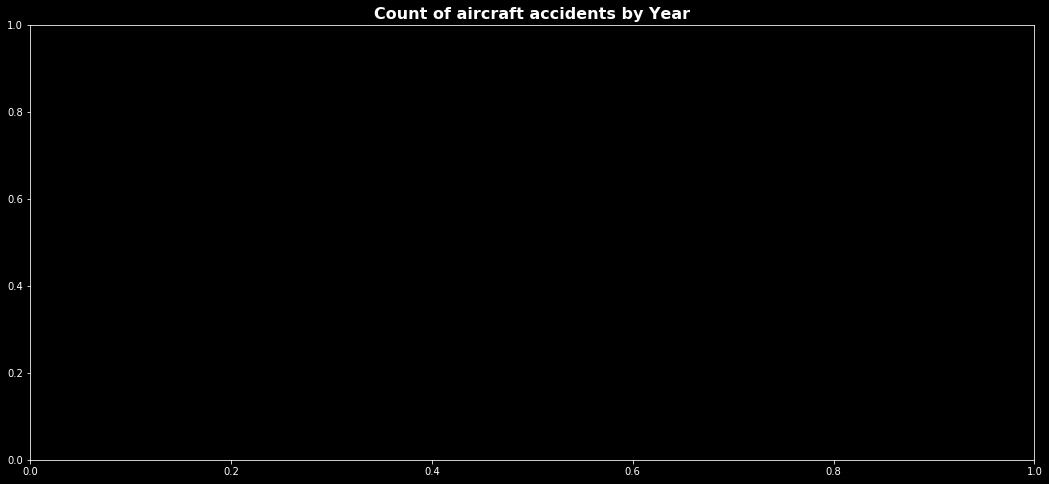

In [45]:
plot_countplot(
    df, 
    'year', 
    hue_column=None, 
    figsize=(18, 8), 
    palette="red",
    title='Count of aircraft accidents by Year'

)

In [ ]:
temp = df.groupby('year')[['id']].count()
temp = temp.rename(columns={"id": "Count"})

plt.figure(figsize=(18, 8))
plt.style.use('bmh')
sns.barplot(data=temp, x=temp.index, y='Count')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90, fontsize=9)
plt.title('Count of aircraft accidents by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
temp = df[df['nature_group'] == 'Passenger'].groupby('year')[['id']].count()
temp = temp.rename(columns={"id": "Count"})

plt.figure(figsize=(18, 8))
plt.style.use('bmh')
sns.barplot(data=temp, x=temp.index, y='Count')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90, fontsize=9)
plt.title('Count of Passenger aircraft accidents by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
temp = df[df['total_fatalities'] > 0].groupby('year')[['id']].count()
temp = temp.rename(columns={"id": "Count"})

plt.figure(figsize=(18, 8))
plt.style.use('bmh')
sns.barplot(data=temp, x=temp.index, y='Count')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90, fontsize=9)
plt.title('Count of aircraft accidents with fatalities by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
temp = df[(df['nature_group'] == 'Passenger') & (df['total_fatalities'] > 0) ].groupby('year')[['id']].count()
temp = temp.rename(columns={"id": "Count"})

plt.figure(figsize=(18, 8))
plt.style.use('bmh')
sns.barplot(data=temp, x=temp.index, y='Count')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=90, fontsize=9)
plt.title('Count of Passenger aircraft accidents with fatalities by Year', loc='Center', fontsize=14)
plt.tight_layout()
plt.show()